# Reporte analítica de datos - Proyecto de Grado II

## Modelamiento de los datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import datetime as datetime
import math
import warnings
import scipy
import fbprophet

In [3]:
data = pd.read_csv('../dengue_data/Data.csv')
df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df['Date'])
df['Age'] = df['Age'].astype(float)
df.set_index('Id', inplace=True)
df.head(10)

,City,Date,Age,Gender,Neighborhood,Commune
Id,,,,,,
1,Buga,2010-01-14,23.0,F,LA MERCED,4
2,Buga,2010-01-11,23.0,F,EL CARMELO,6
3,Buga,2010-01-10,20.0,M,EL CARMELO,6
4,Buga,2010-01-12,6.0,F,SUCRE,3
5,Buga,2010-01-07,13.0,M,POPULAR,5
6,Buga,2010-03-08,20.0,M,DIVINO NINO,3
7,Buga,2010-03-13,18.0,F,DIVINO NINO,3
8,Buga,2010-03-07,36.0,M,ALTO BONITO,1
9,Buga,2010-03-15,40.0,M,EL JARDIN,5


In [4]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)

    list = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        try: 
            list.append(nb_df.at[date,'Cases'])
        except:  
            list.append(0)
            
    final_model = pd.DataFrame(columns=('Date', 'Cases'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, list[i]]
        
    return final_model

## MODELAMIENTO

### Predicciones de modelo AR

In [5]:
def AR_model(df_zeros, nb_name) :

    df_zeros['Values_shifted'] = df_zeros['Cases'].shift()

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = df_zeros.loc[: fecha_1]
    df_test = df_zeros.loc[fecha_2: ]

    df_train = df_train.rename_axis('Date').reset_index()
    df_test = df_test.rename_axis('Date').reset_index()

    df_train.drop('Date', axis=1, inplace=True)
    df_train.dropna(inplace=True)
    df_test.drop('Date', axis=1, inplace=True)
    df_test.dropna(inplace=True)

    y1 = df_train.Cases.values
    X1 = df_train.Values_shifted.values

    y2 = df_test.Cases.values
    X2 = df_test.Values_shifted.values

    # Entrenamiento del modelo
    X_train, X_test = X1, X2
    y_train, y_test = y1, y2

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr.coef_
    lr.intercept_
    y_pred = lr.predict(X_test)

    # Mostrar el modelo
    plt.plot(y_test[-1095:], label="Actual Values")
    plt.plot(y_pred[-1095:], label="Predicted Values")
    plt.legend()
    plt.title(nb_name)  
    plt.ylabel("Número de casos")  
    plt.show()

    # Análisis del modelo
    model = ARIMA(y_train, order=(1,0,0))
    model = model.fit()
    model.predict(365)
    print(model.summary())

In [7]:
def AR_model2(series, nb_name) :

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.values

    y2 = df_test.values

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = 1000
    model = AutoReg(train, lags=1000)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(abs(np.round(float(yhat))))
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(25,5))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(nb_name)  
    pyplot.ylabel("Número de casos") 
    pyplot.xlabel("Días a predecir") 
    pyplot.show()

In [30]:
def runModel(neighborhoods_df, city) :

    for neighborhood_name in neighborhoods_df.index :
        # Obtención conjunto entrenamiento
        if city == 'Buga' :
            nb_df = dfBuga[dfBuga.Neighborhood == neighborhood_name]
        elif city == 'Giron' :
            nb_df = dfGiron[dfGiron.Neighborhood == neighborhood_name]
        else :
            nb_df = dfYopal[dfYopal.Neighborhood == neighborhood_name]
        nb_df = pd.DataFrame(nb_df['Date'].value_counts().sort_index())
        nb_df.columns = ['Cases']
        nb_df.index.name = 'Date'
        if nb_df['Cases'].sum() >= 100 :
            df_zeros = assign_zeros(nb_df)
            df_zeros.set_index('Date',inplace=True)

            # Ejecución del modelo AR
            AR_model2(df_zeros, neighborhood_name)

### BUGA

In [9]:
dfBuga = df[df.City == 'Buga']

Test RMSE: 0.176


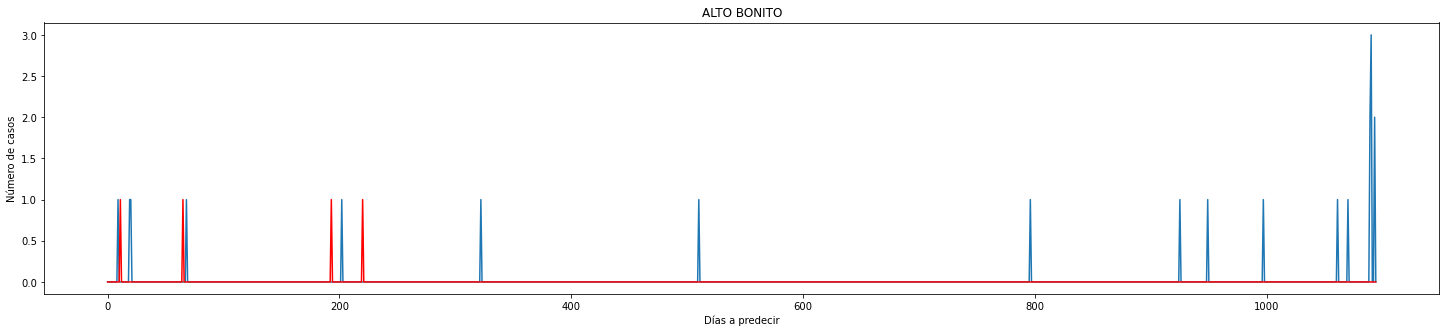

Test RMSE: 0.304


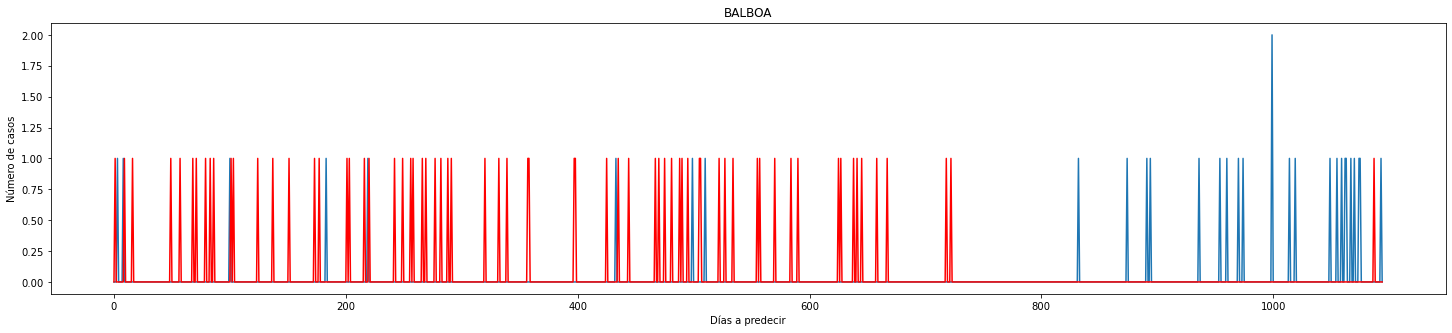

Test RMSE: 0.242


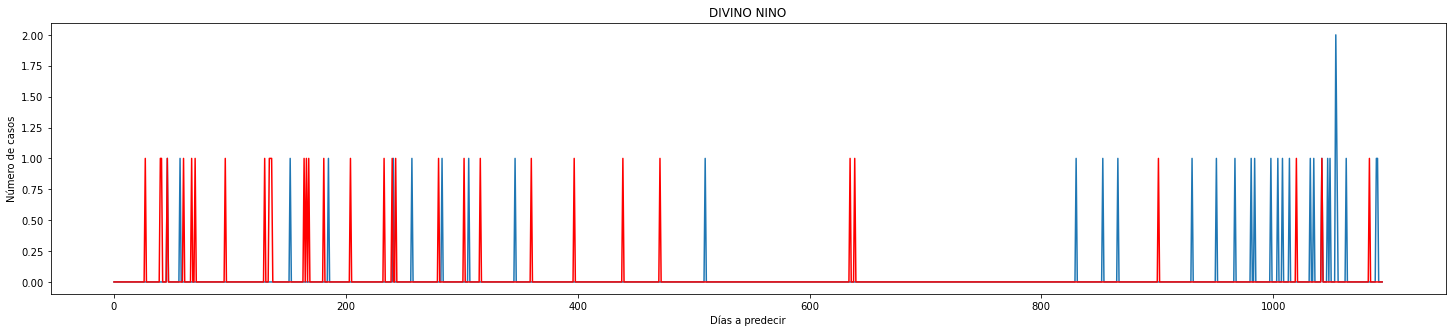

Test RMSE: 0.220


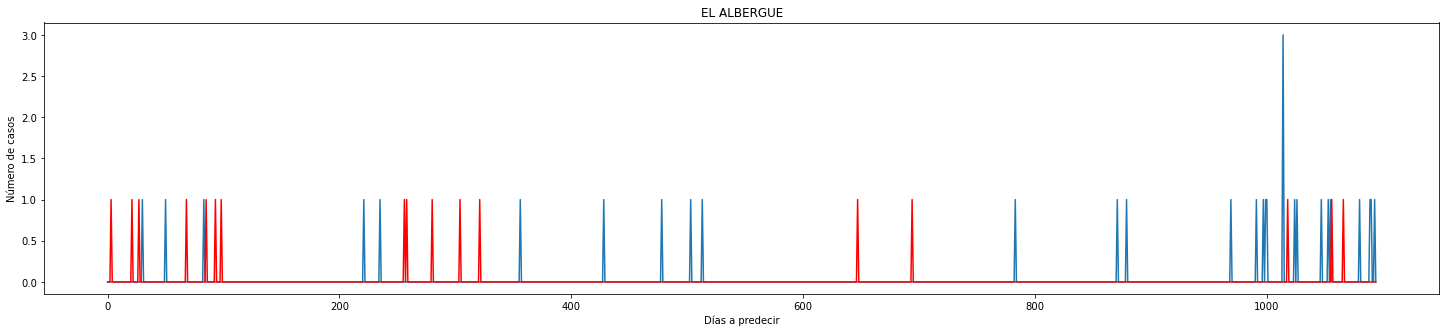

Test RMSE: 0.191


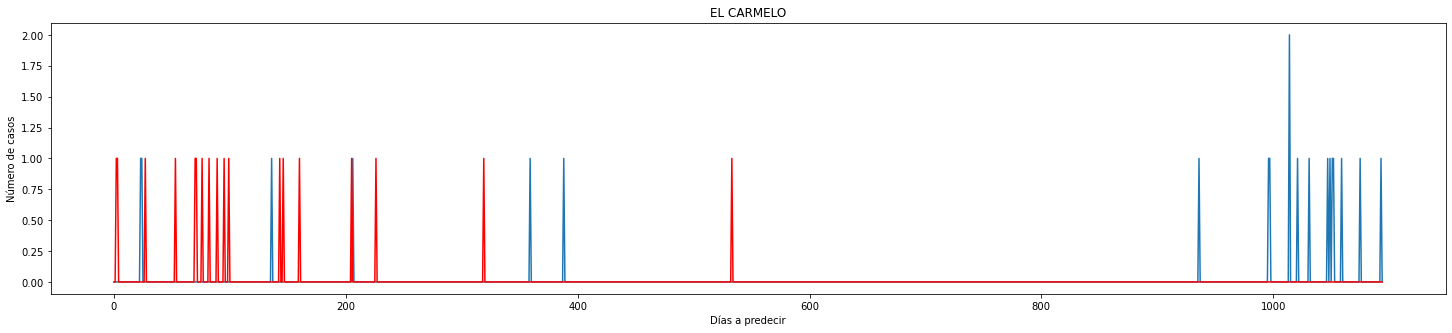

Test RMSE: 0.209


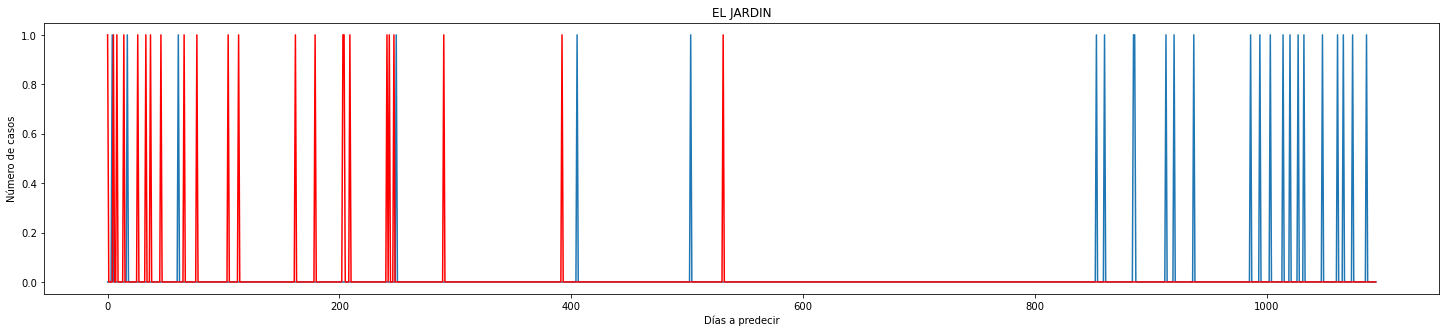

Test RMSE: 0.228


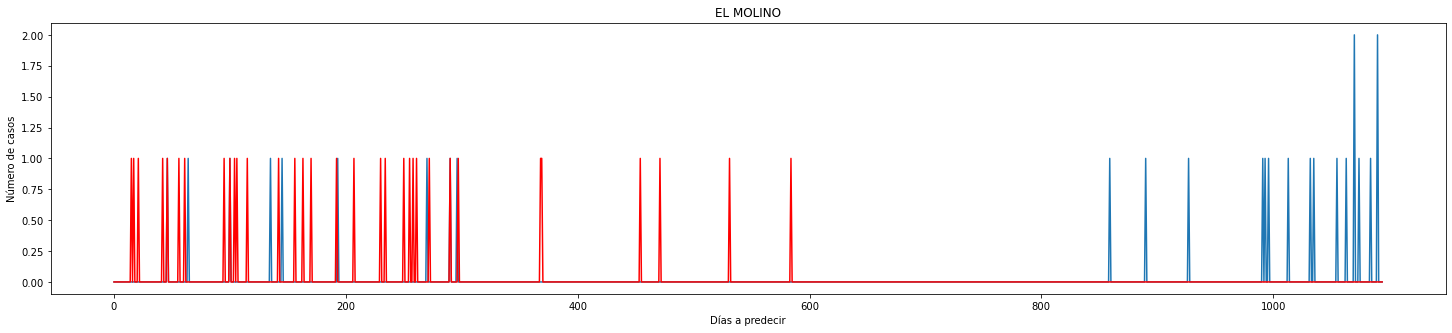

Test RMSE: 0.444


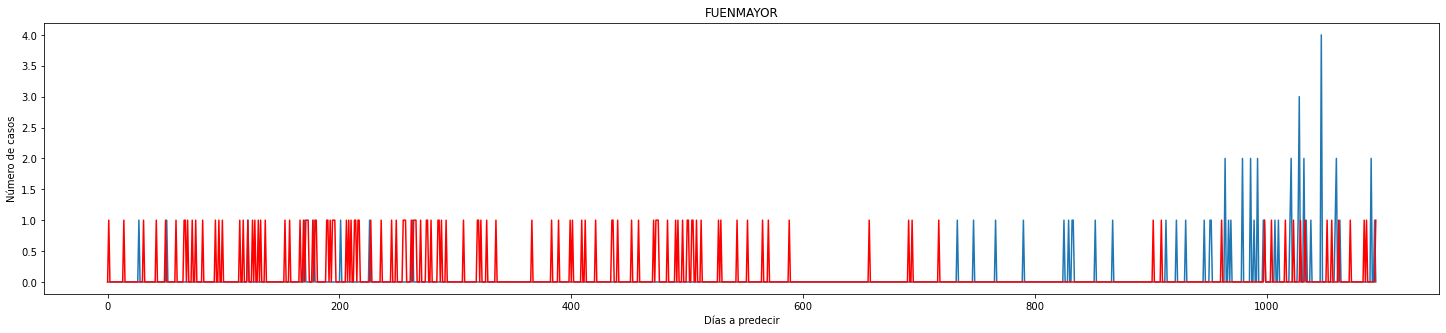

Test RMSE: 0.207


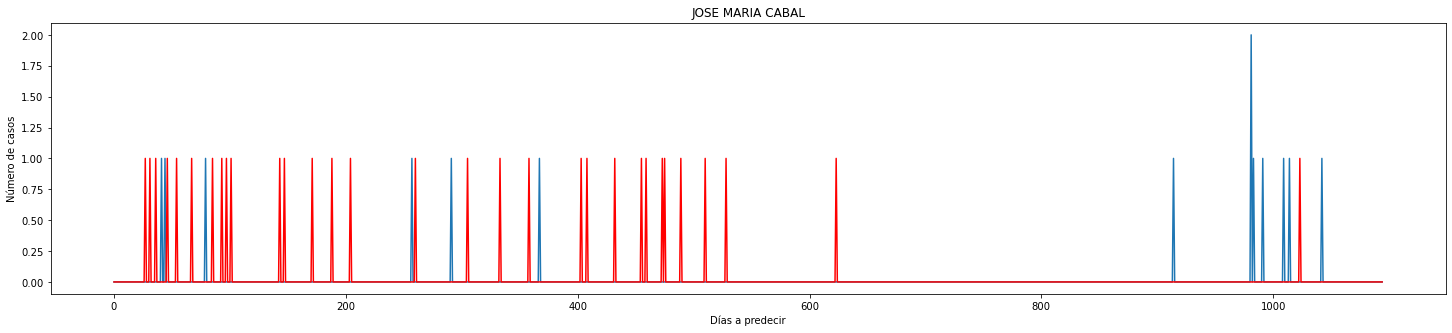

Test RMSE: 0.393


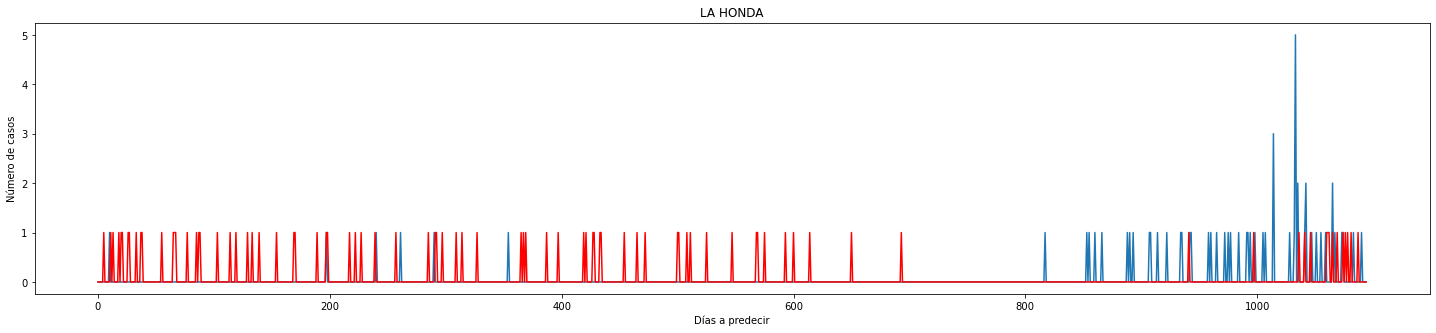

In [ ]:
neighborhoods_df = dfBuga['Neighborhood'].value_counts().sort_index()
runModel(neighborhoods_df, 'Buga')

In [11]:
nb_df = dfBuga[dfBuga.Neighborhood == "SANTA BARBARA"]
nb_df = pd.DataFrame(nb_df['Date'].value_counts().sort_index())
nb_df.columns = ['Cases']
nb_df.index.name = 'Date'
df_zeros = assign_zeros(nb_df)
df_zeros

,Date,Cases
0,2010-01-01,0
1,2010-01-02,0
2,2010-01-03,0
3,2010-01-04,0
4,2010-01-05,0
...,...,...
3647,2019-12-27,0
3648,2019-12-28,0
3649,2019-12-29,0
3650,2019-12-30,0


### GIRÓN

In [10]:
dfGiron = df[df.City == 'Girón']

Test RMSE: 0.074


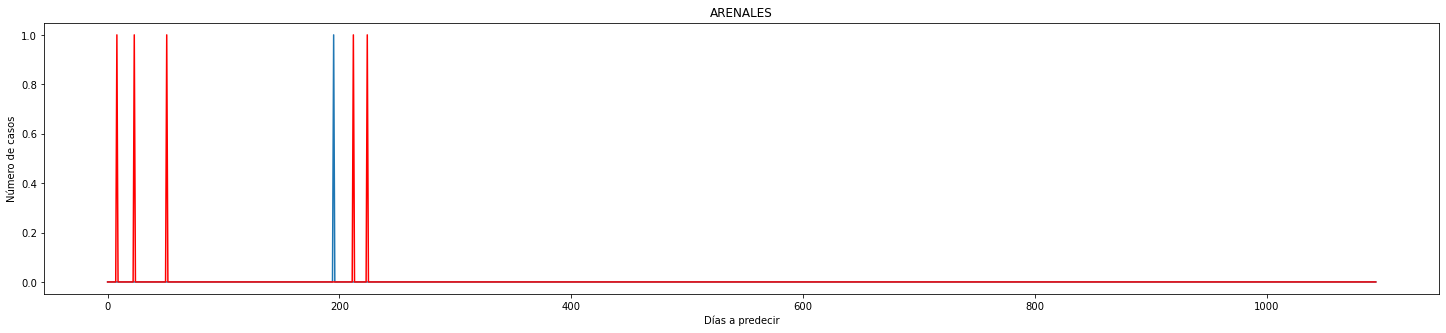

Test RMSE: 0.218


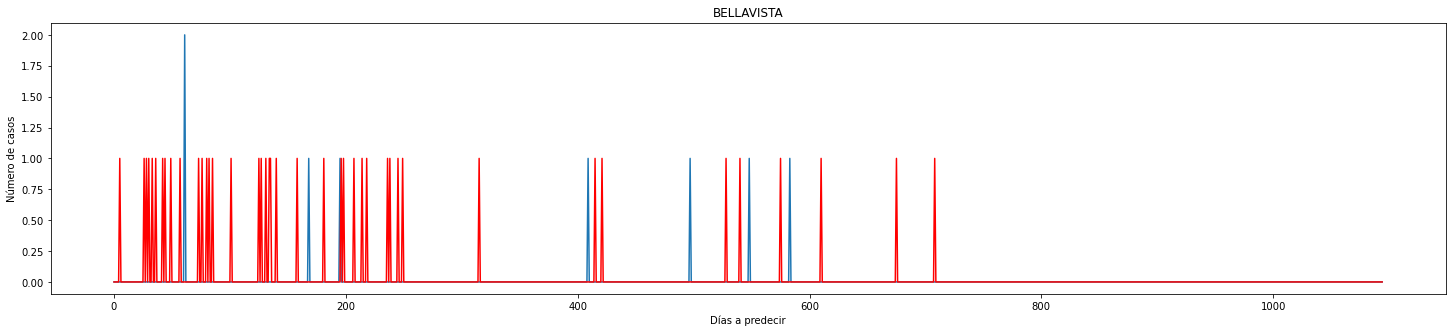

Test RMSE: 0.324


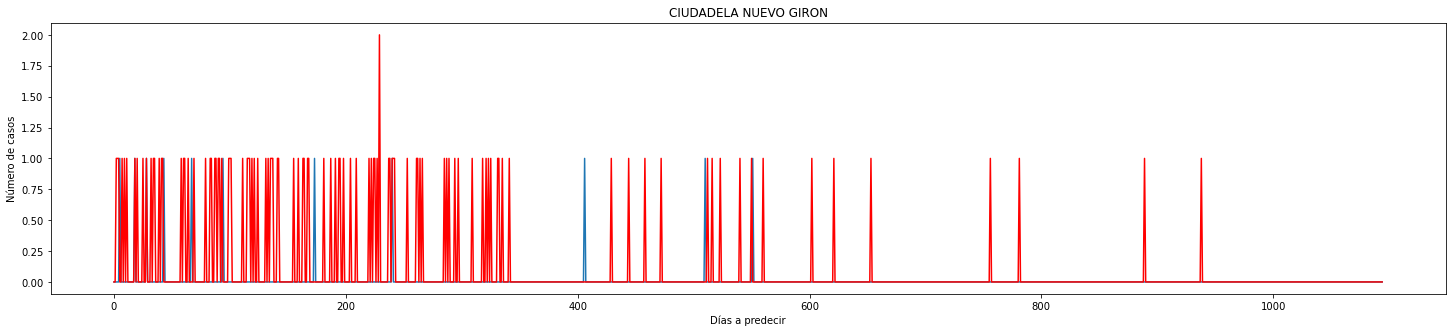

Test RMSE: 0.091


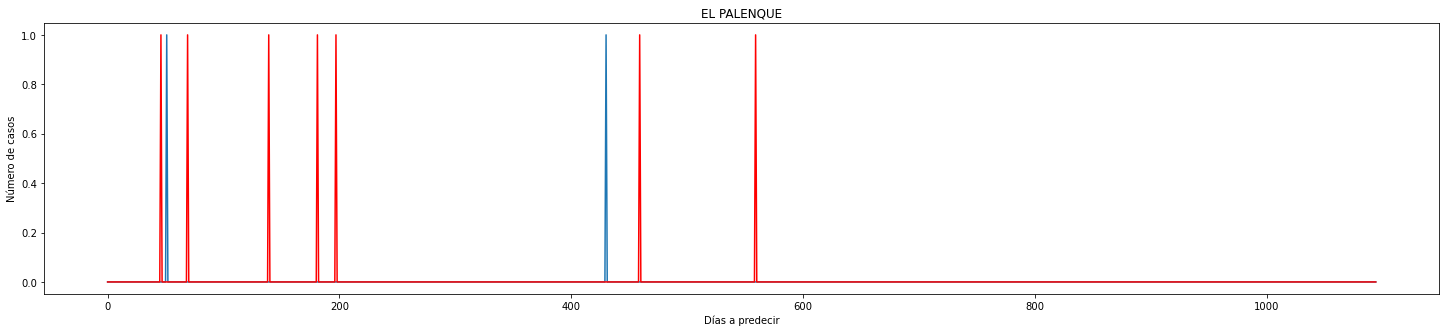

Test RMSE: 0.341


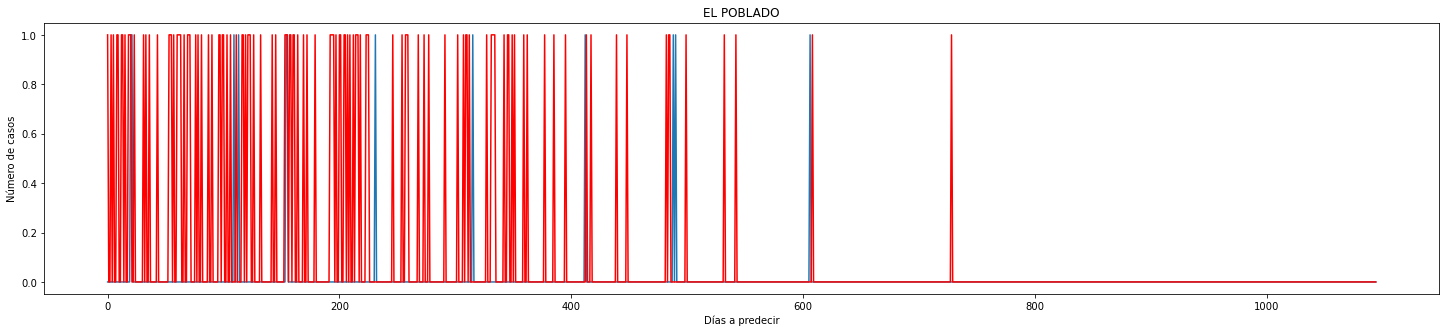

Test RMSE: 0.145


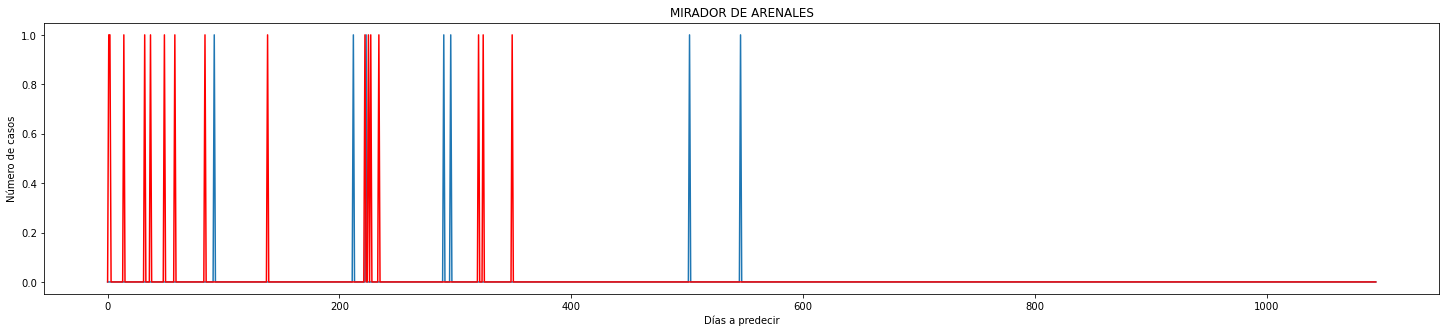

Test RMSE: 0.226


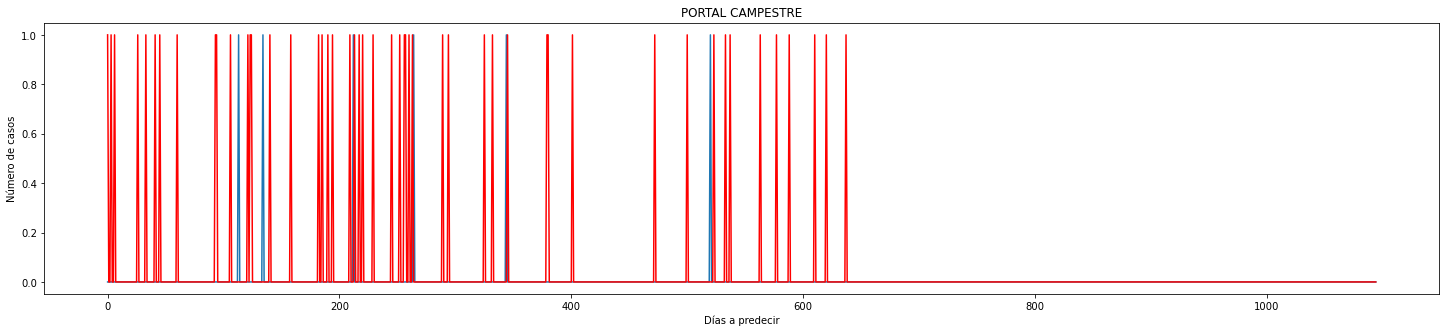

Test RMSE: 0.472


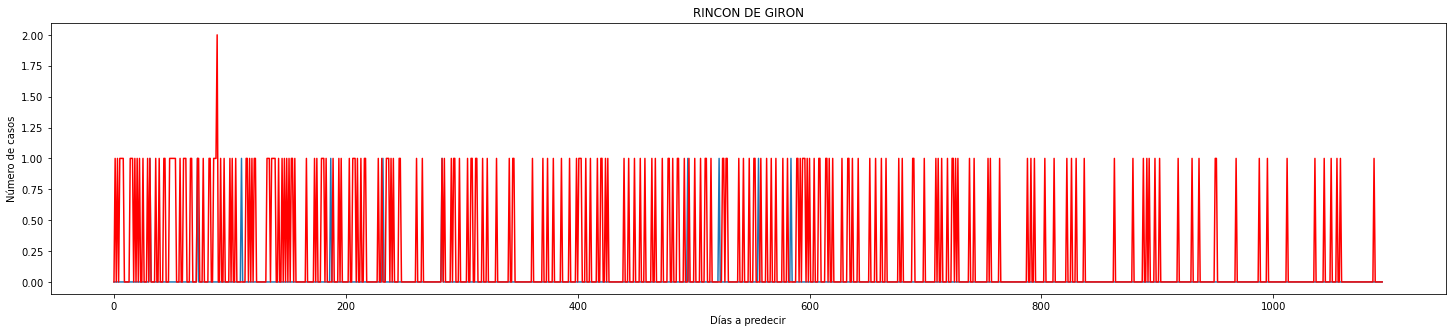

Test RMSE: 0.191


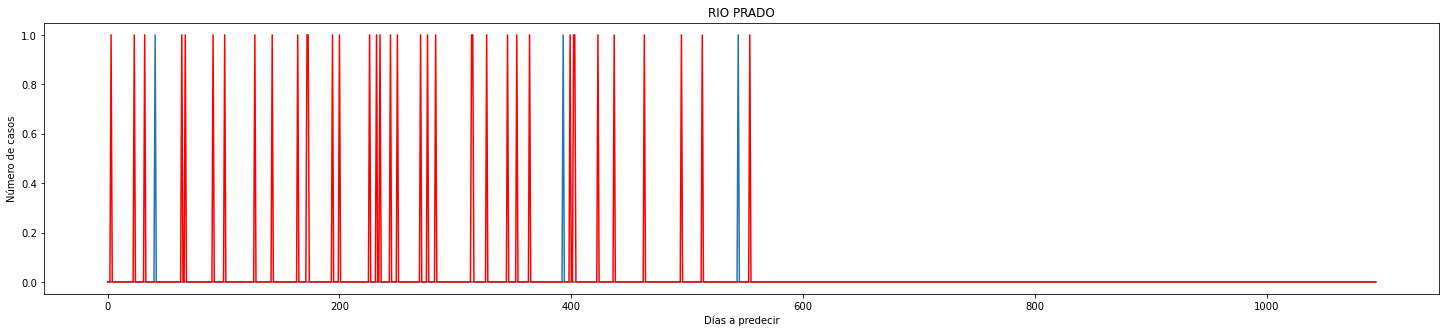

Test RMSE: 0.184


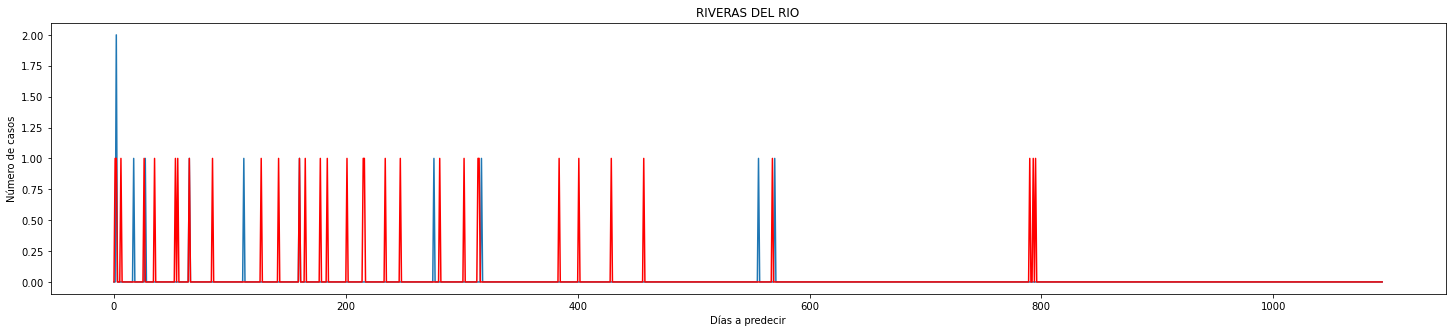

Test RMSE: 0.207


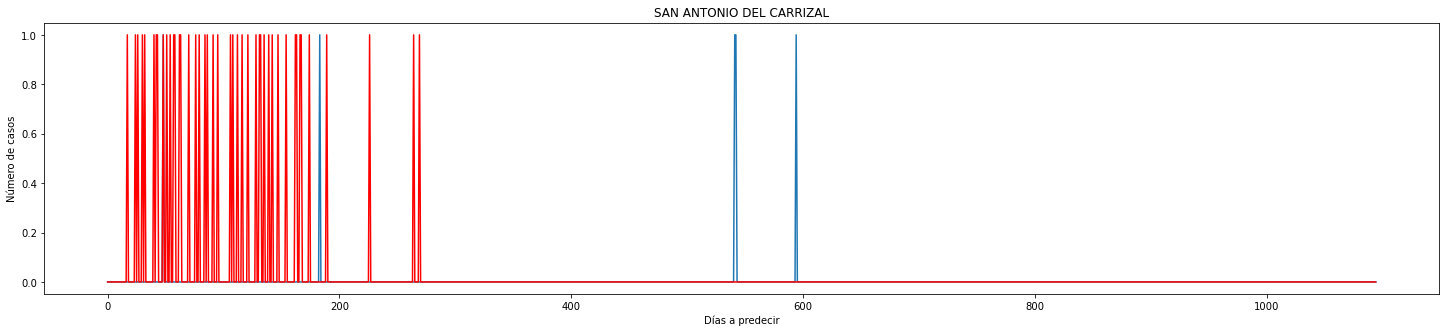

Test RMSE: 0.232


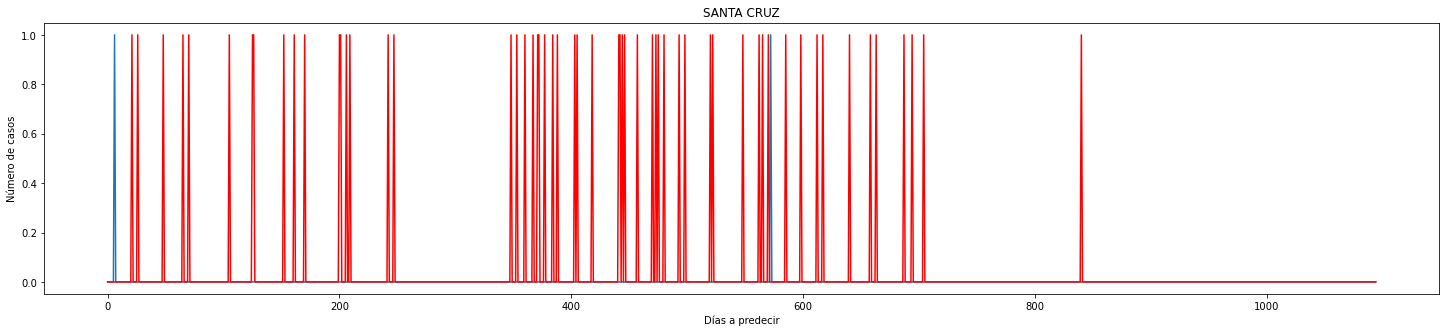

Test RMSE: 0.085


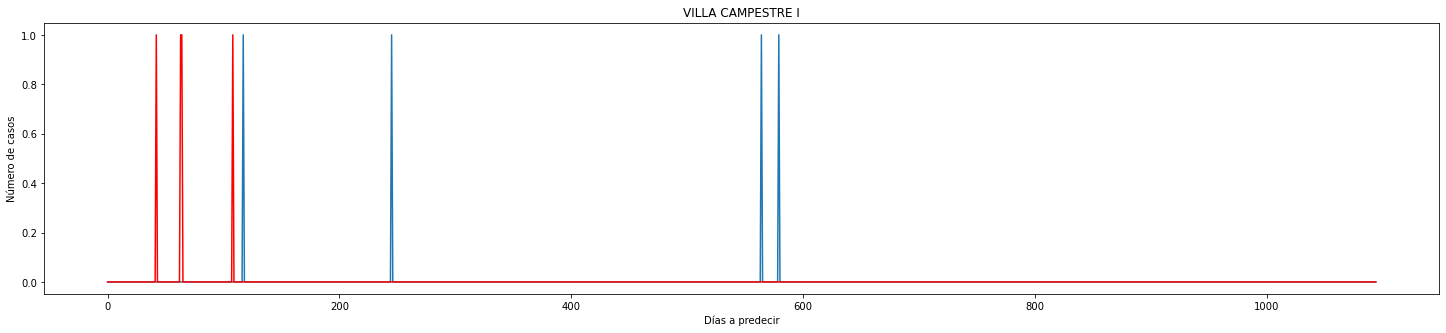

Test RMSE: 0.189


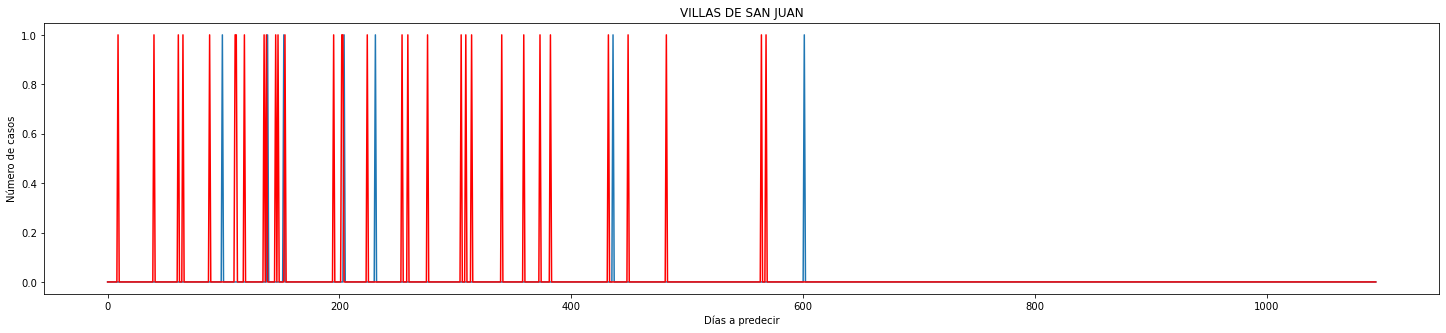

In [11]:
neighborhoods_df = dfGiron['Neighborhood'].value_counts().sort_index()
runModel(neighborhoods_df, 'Giron')

### YOPAL

In [24]:
dfYopal = df[df.City == 'Yopal']

In [ ]:
neighborhoods_df = dfYopal['Neighborhood'].value_counts().sort_index()
runModel(neighborhoods_df, 'Yopal')

## MODELO CON FBPROPHET

In [25]:
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

### BUGA

          ds      yhat  yhat_lower  yhat_lower
0 2019-01-01  0.007051   -0.315685   -0.315685
1 2019-02-01  0.114724   -0.247889   -0.247889
2 2019-03-01  0.100074   -0.227967   -0.227967
3 2019-04-01  0.049524   -0.270340   -0.270340
4 2019-05-01  0.048186   -0.289945   -0.289945


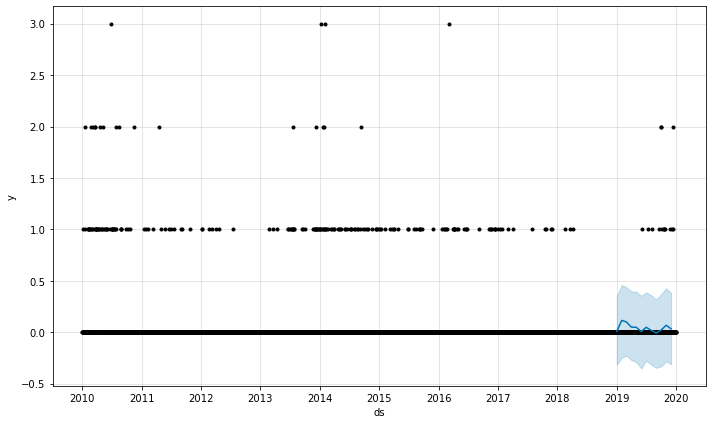

In [26]:
# prepare expected column names
df_zeros.columns = ['ds', 'y']
df_zeros['ds']= to_datetime(df_zeros['ds'])
# define the model
model = Prophet(daily_seasonality=True)
# fit the model
model.fit(df_zeros)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2019-%01d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
#forecast[['yhat', 'yhat_lower','yhat_lower']] = forecast[['yhat', 'yhat_lower','yhat_lower']].astype(float)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_lower']].head())
#plot forecast
model.plot(forecast)
pyplot.show()

          ds      yhat  yhat_lower  yhat_upper
0 2020-01-01  0.035394   -0.281149    0.402207
1 2020-02-01  0.076645   -0.257685    0.399962
2 2020-03-01  0.008320   -0.365989    0.360783
3 2020-04-01  0.079452   -0.263283    0.413485
4 2020-05-01  0.108075   -0.243861    0.472034


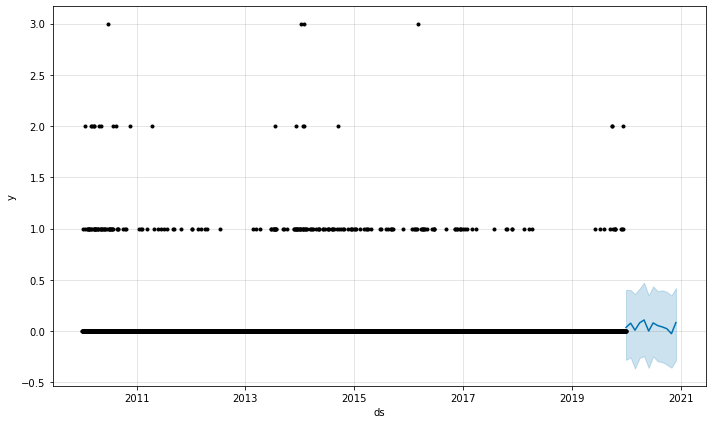

In [27]:
# load data
df_zeros.columns = ['ds', 'y']
df_zeros['ds']= to_datetime(df_zeros['ds'])
# define the model
model = Prophet(daily_seasonality=True)
# fit the model
model.fit(df_zeros)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%01d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

             ds  y
3635 2019-12-15  0
3636 2019-12-16  0
3637 2019-12-17  0
3638 2019-12-18  0
3639 2019-12-19  0
MAE: 0.045


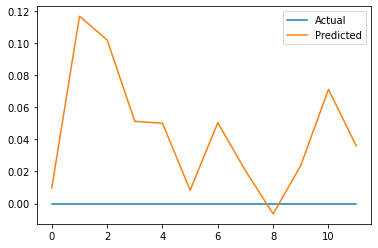

In [24]:
df_zeros.columns = ['ds', 'y']
df_zeros['ds']= to_datetime(df_zeros['ds'])
# create test dataset, remove last 12 months
train = df_zeros.drop(df_zeros.index[-12:])
print(train.tail())
# define the model
model = Prophet(daily_seasonality=True)
# fit the model
model.fit(train)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2019-%01d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = df_zeros['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()